In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import MazeEnv as mz
from MazeEnv import Rewards
import time
import numpy as np
import pandas as pd
from stable_baselines3 import DDPG
from Evaluation import EvalAndSaveCallback, moving_average
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env

import torch
torch.cuda.is_available()

True

In [26]:
def make_circular_map(size, radius):
    center = np.divide(size, 2)
    x, y = np.ogrid[:size[0], :size[1]]
    maze_map = np.where(np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2) > radius, 1, 0)

    return maze_map

In [27]:
START_LOC = (5, 3.2)
TIMEOUT_STEPS = 200
BUFFER_SIZE = 1000 # smaller buffer for small task
TOTAL_TIME_STEPS = 10000
LEARNING_RATE = 0.001

REWARDS = Rewards(target_arrival=1, collision=-1, timeout=-0.5)

EVAL_EPISODES=5
EVAL_FREQ=500
VIDEO_FREQ=6

In [28]:
# create environment :
tile_size = 0.1
maze_size = mz.MazeSize.SQUARE10
map_size = np.dot(maze_size, int(1 / tile_size))
maze_map = make_circular_map(map_size, 3 / tile_size)
# maze_map = np.zeros(map_size)

maze_env = Monitor(mz.MazeEnv(maze_size=maze_size,
                              maze_map=maze_map,
                              tile_size=tile_size,
                              start_loc=START_LOC,
                              target_loc=np.divide(maze_size, 2),
                              timeout_steps=TIMEOUT_STEPS,
                              show_gui=False,
                              rewards=REWARDS), 
                  filename="logs/DummyMaze/results")
_ = maze_env.reset()

check_env(maze_env)

# create separete evaluation environment:
eval_maze_env = Monitor(mz.MazeEnv(maze_size=maze_size,
                                   maze_map=maze_map,
                                   tile_size=tile_size,
                                   start_loc=START_LOC,
                                   target_loc=np.divide(maze_size, 2),
                                   timeout_steps=TIMEOUT_STEPS,
                                   show_gui=False,
                                   rewards=REWARDS)
                       )
_ = eval_maze_env.reset()
 
# create model:
model = DDPG(policy="MlpPolicy",
             env=maze_env,
             buffer_size=BUFFER_SIZE,
             learning_rate=LEARNING_RATE,
             device='cuda',
             train_freq=(1, "episode"),
             verbose=1)

# create callback for evaluation
callback = EvalAndSaveCallback(log_dir="logs/DummyMaze",
                               eval_env=eval_maze_env,
                               eval_freq=EVAL_FREQ,
                               eval_episodes=EVAL_EPISODES,
                               eval_video_freq=VIDEO_FREQ,
                               verbose=1)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [29]:
start = time.time()

model.learn(total_timesteps=TOTAL_TIME_STEPS,
            callback=callback,)

print("time", time.time() - start)

500 Steps evaluation, avg reward:-0.5, avg episode length: 200.0
--Saving new best smodel--
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 185      |
|    ep_rew_mean     | -0.125   |
| time/              |          |
|    episodes        | 4        |
|    fps             | 238      |
|    time_elapsed    | 3        |
|    total timesteps | 739      |
| train/             |          |
|    actor_loss      | -0.00733 |
|    critic_loss     | 0.00179  |
|    learning_rate   | 0.001    |
|    n_updates       | 600      |
---------------------------------
1000 Steps evaluation, avg reward:-0.5, avg episode length: 200.0
1500 Steps evaluation, avg reward:-0.5, avg episode length: 200.0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 192      |
|    ep_rew_mean     | -0.312   |
| time/              |          |
|    episodes        | 8        |
|    fps             | 210      |
|    time_elapsed    | 7    

Text(0.5, 0, 'Step')

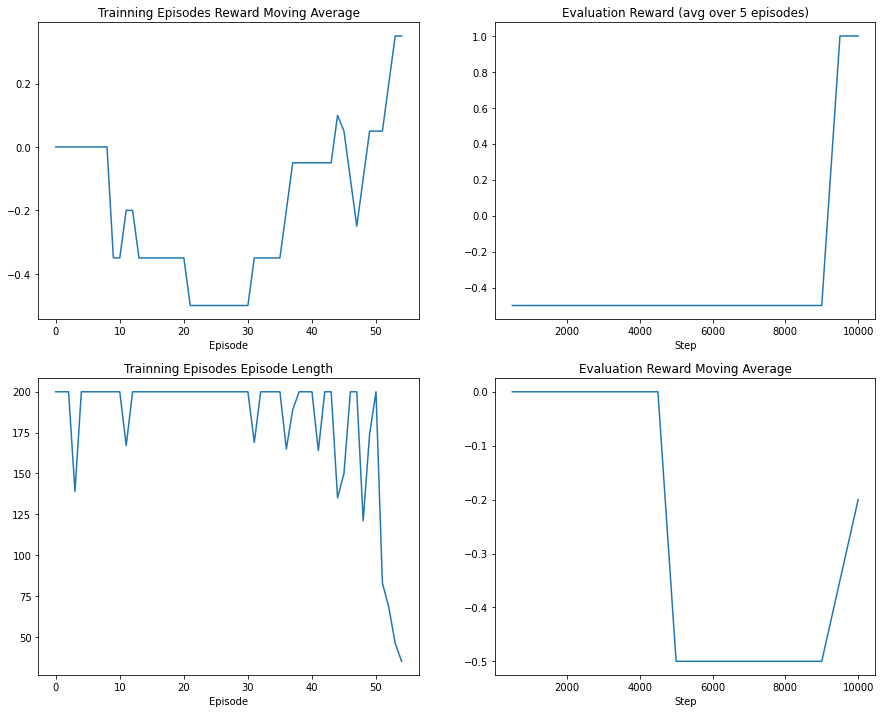

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(15,12))

results_df = pd.read_csv("logs/DummyMaze/results.monitor.csv", header=1)
eval_results_df = pd.read_csv("logs/DummyMaze/eval_results.csv",
                         names=["Step", "Avg Reward", "Avg Episode Length"],
                         index_col=0)

episode = results_df.index.to_numpy()
reward = results_df["r"].to_numpy()
reward_moving_avg = moving_average(reward, kernel_size=10)
episode_length= results_df["l"].to_numpy()

axes[0, 0].plot(episode, reward_moving_avg)
axes[0, 0].set_title("Trainning Episodes Reward Moving Average")
axes[0, 0].set_xlabel("Episode")

axes[1, 0].plot(episode, episode_length)
axes[1, 0].set_title("Trainning Episodes Episode Length")
axes[1, 0].set_xlabel("Episode")


eval_results_df.plot(y="Avg Reward", ax=axes[0,1], legend=None)
axes[0, 1].set_title("Evaluation Reward (avg over {eval_episodes} episodes)".format(eval_episodes=EVAL_EPISODES))

steps = eval_results_df.index.to_numpy()
eval_reward = eval_results_df["Avg Reward"].to_numpy()
eval_reward_moving_avg = moving_average(eval_reward, kernel_size=10)
axes[1, 1].plot(steps, eval_reward_moving_avg)
axes[1, 1].set_title("Evaluation Reward Moving Average")
axes[1, 1].set_xlabel("Step")



In [31]:
# load best model 
best_model = DDPG.load("./logs/DummyMaze/best_model")

# evaluate the best model
episode_reward = 0
obs = eval_maze_env.reset(create_video=True, video_path="logs/DummyMaze/final.avi")
while True:
    action, _ = best_model.predict(obs, deterministic=True)
    obs, reward, done, _ = eval_maze_env.step(action)
    episode_reward += reward
    if done:
        print("Reward:", episode_reward)
        break
        


Reward: 1


In [32]:
import imageio
import sys
import glob
import os

def create_gifs_from_avi(log_directory_path):
    in_files_path = glob.glob(log_directory_path + "/*.avi")
    out_files_path = [os.path.splitext(in_pth)[0] + ".gif" for in_pth in in_files_path]

    for in_path, out_path in zip(in_files_path, out_files_path):
        reader = imageio.get_reader(in_path)
        fps = reader.get_meta_data()['fps']
        writer = imageio.get_writer(out_path, fps=fps)

        for i,im in enumerate(reader):
            writer.append_data(im)
            
        writer.close()

create_gifs_from_avi("logs/DummyMaze")


In [33]:
from IPython.display import Image
import ipyplot

gifs = glob.glob("logs/DummyMaze/*.gif")

labels = [pth.split('/')[-1].split('.')[0] for pth in gifs]
ipyplot.plot_images(gifs, labels, img_width=250)

# Gradually trainning

Up until here, it only worked to train the robot to get to the target when it starts really close to it. When taking it a little bit farther we would need a lot of luck to make it learn.

Here we are trying to train, and each *m* steps change the envrionment so the robot starts a little bit farther from the target and the circle radius is a little bit bigger, and it has a little bit more steps so it can learn gradually.

In [49]:
BUFFER_SIZE = 1000 # smaller buffer for small task
# TOTAL_TIME_STEPS = 10000
LEARNING_RATE = 0.001

REWARDS = Rewards(target_arrival=1, collision=-1, timeout=-0.5)

EVAL_EPISODES=5
EVAL_FREQ=200
VIDEO_FREQ=5

CHANGE_ENV_EVERY = 1000

START_LOC_X = [5]*10
START_LOC_Y = np.around(np.linspace(3.3, 2.4, 10), 1)
START_LOCATIONS = list(zip(START_LOC_X, START_LOC_Y))
print("Start locations:\n", START_LOCATIONS)
MAZE_RADIUSES = np.around(np.linspace(2.9, 3.8, 10), 1)
print("Maze Radiuses:\n", MAZE_RADIUSES)
TIMEOUT_STEPS = np.linspace(150, 330, 10)
print("Timeout Steps:\n", TIMEOUT_STEPS)

Start locations:
 [(5, 3.3), (5, 3.2), (5, 3.1), (5, 3.0), (5, 2.9), (5, 2.8), (5, 2.7), (5, 2.6), (5, 2.5), (5, 2.4)]
Maze Radiuses:
 [2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8]
Timeout Steps:
 [150. 170. 190. 210. 230. 250. 270. 290. 310. 330.]


In [50]:
from copy import deepcopy

tile_size = 0.1
maze_size = mz.MazeSize.SQUARE10
map_size = np.dot(maze_size, int(1 / tile_size))

# create callback for evaluation
callback = EvalAndSaveCallback(log_dir="logs/DummyMaze/gradual",
                               eval_env=eval_maze_env,
                               eval_freq=EVAL_FREQ,
                               eval_episodes=EVAL_EPISODES,
                               eval_video_freq=VIDEO_FREQ,
                               verbose=1)

model = DDPG(policy="MlpPolicy",
             env=maze_env,
             buffer_size=BUFFER_SIZE,
             learning_rate=LEARNING_RATE,
             device='cuda',
             train_freq=(1, "episode"),
             verbose=1)

for start_loc, radius, timeout_steps in zip(START_LOCATIONS, MAZE_RADIUSES, TIMEOUT_STEPS):
    maze_map = make_circular_map(map_size, radius / tile_size)

    maze_env = Monitor(mz.MazeEnv(maze_size=maze_size,
                                  maze_map=maze_map,
                                  tile_size=tile_size,
                                  start_loc=start_loc,
                                  target_loc=np.divide(maze_size, 2),
                                  timeout_steps=timeout_steps,
                                  show_gui=False,
                                  rewards=REWARDS), 
                      filename="logs/DummyMaze/gradual/results")
    _ = maze_env.reset()

    check_env(maze_env)

    # create separete evaluation environment:
    eval_maze_env = deepcopy(maze_env.env)
    callback.eval_env = eval_maze_env
    
    model.learn(total_timesteps=CHANGE_ENV_EVERY,
            callback=callback,)


Using cuda device
Wrapping the env in a DummyVecEnv.


FileNotFoundError: [Errno 2] No such file or directory: 'logs/DummyMaze/gradual/results.monitor.csv'